In [91]:
import pandas as pd
import numpy as np
import catboost as cbt
from sklearn.metrics import accuracy_score, roc_auc_score,log_loss
import gc
import math
import time
import datetime
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import warnings
import seaborn as sns
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from sklearn.feature_extraction import stop_words

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from matplotlib.font_manager import FontProperties

font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)

In [92]:
#数据导入
file_path = './Problem_C_Data/hair_dryer.tsv'
messages = pd.read_csv(file_path, sep='\t', header=0)
messages.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,34678741,R9T1FE2ZX2X04,B003V264WW,732252283,remington ac2015 t|studio salon collection pea...,Beauty,5,0,0,N,Y,Works great,Works great!,8/31/2015
1,US,11599505,RE36JAD5V53PO,B0009XH6V4,670161917,andis micro turbo hair dryer,Beauty,4,0,0,N,Y,I love travel blow dryers because they are eas...,"This dries my hair faster that bigger, more po...",8/31/2015
2,US,2282190,RIDHM8B7SCCV3,B0007NZPY6,16483457,conair pro hair dryer,Beauty,5,0,1,N,Y,Five Stars,Love this dryer!,8/31/2015
3,US,43669858,R14QGWPCHU9LSE,B00BB8ZIW0,253917972,remington silk ceramic professional hair dryer,Beauty,5,0,0,N,Y,Five Stars,styling hair in style,8/31/2015
4,US,107098,R35BHQJHXXJD59,B003V264WW,732252283,remington ac2015 t|studio salon collection pea...,Beauty,4,0,0,N,N,I think's great. The cord length is perfect,I just got this last week. I think's great. Th...,8/31/2015


In [93]:
messages["Usefulness"] = (messages["helpful_votes"]/messages["total_votes"]).apply(lambda n: "useful" if n > 0.5 else "useless")

messages['Summary'] = messages['review_body']
messages['Date'] = messages.review_date.apply(lambda x : pd.to_datetime(x))
messages = messages.drop(['review_headline','review_body','review_date','marketplace','customer_id','product_id','product_parent','product_category'], axis=1)
messages = messages.set_index('Date')
messages= messages.sort_values(['Date'])
messages.head()

,review_id,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,Usefulness,Summary
Date,,,,,,,,,
2002-03-02,R2XM83JYE2KDE2,conair corp pers care 146np conair ionic condi...,3,320,332,N,Y,useful,This is my only experience with an ionic hair ...
2002-04-20,R3JMGN42OJCL97,conair corp pers care 146np conair ionic condi...,5,78,87,N,N,useful,This hairdryer far exceeded my expection for<B...
2002-07-13,R3GO6L5PWBS0IW,conair corp pers care 146np conair ionic condi...,5,4,4,N,Y,useful,"I love this dryer not only is it QUIET, it rea..."
2002-08-13,R2JQPUYU65C4QD,conair corp pers care 146np conair ionic condi...,1,26,32,N,N,useful,I purchased it because it was supposed to be q...
2002-08-21,R2O50YNP83CG34,revlon 1875w volumizing hair dryer,5,14,18,N,N,useful,"I just purchased this dryer, and I really like..."


In [94]:
final = messages[messages['star_rating'] != 3]
def partition(x):
    if x>3:
        return 'positive'
    return 'negative'

actual_score = final['star_rating']
positiveNegative = actual_score.map(partition)
final['Score'] = positiveNegative


import re
# Creating the set of stopwords
stop = set(stopwords.words('english'))
# For stemming purpose
snow = nltk.stem.SnowballStemmer('english')

# Defining function to clean html tags
def cleanhtml(sentence):
    cleaner = re.compile('<.*>')
    cleantext = re.sub(cleaner, ' ', sentence)
    return cleantext

# Defining function to remove special symbols
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|.|!|*|@|#|\'|"|,|)|(|\|/]', r'', sentence)
    return cleaned


# Important steps to clean the text data. Please trace it out carefully
i = 0
str1 = ''
all_positive_words = []
all_negative_words = []
final_string = []
s=''
for sent in final['Summary'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if (cleaned_words.lower() not in stop):
                    s = (snow.stem(cleaned_words.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1)
    i += 1
    
# Adding new column into dataframe to store cleaned text
final['CleanedText'] = final_string
final['CleanedText'] = final['CleanedText'].str.decode('utf-8')


# Getting shape of new datset
print(final.shape)

(10471, 11)


In [95]:
X = final['CleanedText']
y_dict = {'useful':1, 'useless':0}
y = final['Usefulness'].map(y_dict)
# y_dict = {1:0, 2:0, 4:1, 5:1}
# y = final['star_rating'].map(y_dict)

In [96]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, shuffle=False)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    pre = clf.predict_proba(X_train)[:,1]
    oof = clf.predict_proba(X_test)[:,1]
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    return coeff_df,pre,oof
    
    
coeff_df,pre,oof = text_fit(X, y, c, LogisticRegression())

# features: 7860
# train records: 7853
# test records: 2618
Model Accuracy: 0.8174178762414056

-Top 20 positive-
        Word  Coefficient
     panason     1.531156
        form     1.412298
     definet     1.397659
       floss     1.329233
       motel     1.317733
       brown     1.305713
      explod     1.289624
         hsi     1.270684
     african     1.263667
        abil     1.231302
        gone     1.185334
      improv     1.166127
    signific     1.147233
 nonetheless     1.141507
         jet     1.133890
      corner     1.122280
   disapoint     1.110271
       laugh     1.082095
       steal     1.070737
       steam     1.052336

-Top 20 negative-
      Word  Coefficient
      word    -0.995906
      whip    -1.004079
   struggl    -1.007511
   qualifi    -1.032001
      dorm    -1.033892
    bristl    -1.046789
    physic    -1.048001
     paddl    -1.063990
   success    -1.065880
     women    -1.072987
      wrap    -1.099988
 treatment    -1.124589
   tonigh

In [97]:
pre = pd.DataFrame(pre)
oof = pd.DataFrame(oof)
df = pd.concat([pre, oof], axis=0, ignore_index=True)
df.index = final.index
df.columns = ['usefulness']
df.head()

,usefulness
Date,
2002-04-20,0.101077
2002-07-13,0.461106
2002-08-13,0.913628
2002-08-21,0.577239
2002-11-08,0.674253


In [98]:
final = pd.concat([final, df], axis=1)
final.tail()

,review_id,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,Usefulness,Summary,Score,CleanedText,usefulness
Date,,,,,,,,,,,,
2015-08-31,R35BHQJHXXJD59,remington ac2015 t|studio salon collection pea...,4,0,0,N,N,useless,I just got this last week. I think's great. Th...,positive,got last week think great cord length perfect,0.218734
2015-08-31,R14QGWPCHU9LSE,remington silk ceramic professional hair dryer,5,0,0,N,Y,useless,styling hair in style,positive,style hair style,0.109940
2015-08-31,RIDHM8B7SCCV3,conair pro hair dryer,5,0,1,N,Y,useless,Love this dryer!,positive,love dryer,0.142125
2015-08-31,RE36JAD5V53PO,andis micro turbo hair dryer,4,0,0,N,Y,useless,"This dries my hair faster that bigger, more po...",positive,dri hair faster bigger power model love travel...,0.686761
2015-08-31,R9T1FE2ZX2X04,remington ac2015 t|studio salon collection pea...,5,0,0,N,Y,useless,Works great!,positive,work great,0.119101


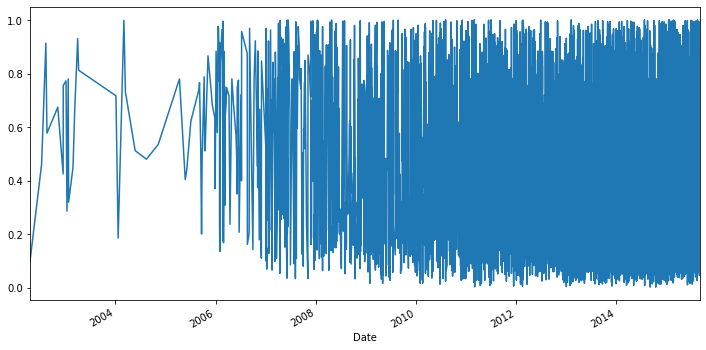

In [99]:
kindle_review_dates = final['usefulness']
kindle_review_dates.sort_index(inplace=True)
kindle_review_dates.plot(figsize=(12,6))
plt.show()

In [100]:
final['vine_num'] = final['vine'].apply(lambda n: 10 if n=='Y' else 1)
final['P'] = final['vine_num']*final['usefulness']
final.head()

,review_id,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,Usefulness,Summary,Score,CleanedText,usefulness,vine_num,P
Date,,,,,,,,,,,,,,
2002-04-20,R3JMGN42OJCL97,conair corp pers care 146np conair ionic condi...,5,78,87,N,N,useful,This hairdryer far exceeded my expection for<B...,positive,hairdryer far exceed expect high recommend fin...,0.101077,1,0.101077
2002-07-13,R3GO6L5PWBS0IW,conair corp pers care 146np conair ionic condi...,5,4,4,N,Y,useful,"I love this dryer not only is it QUIET, it rea...",positive,love dryer quiet realli make hair shini silki ...,0.461106,1,0.461106
2002-08-13,R2JQPUYU65C4QD,conair corp pers care 146np conair ionic condi...,1,26,32,N,N,useful,I purchased it because it was supposed to be q...,negative,purchas suppos quiet everi bit loud old dryer ...,0.913628,1,0.913628
2002-08-21,R2O50YNP83CG34,revlon 1875w volumizing hair dryer,5,14,18,N,N,useful,"I just purchased this dryer, and I really like...",positive,purchas dryer realli like way hair look say dr...,0.577239,1,0.577239
2002-11-08,R33QQ6N5UIPSY1,revlon 1875w volumizing hair dryer,4,4,4,N,N,useful,"Overall, I am extremely pleased with this hair...",positive,overal extrem pleas hair dryer improv textur h...,0.674253,1,0.674253


In [101]:
final['H'] = final['P']*final['star_rating']

In [102]:
for i in range(8):
    title = final['product_title'].value_counts().index[i]
    print(title)

remington ac2015 t|studio salon collection pearl ceramic hair dryer, deep purple
andis 1875-watt fold-n-go ionic hair dryer , silver/black (80020)
conair 1875 watt tourmaline ceramic hair dryer
conair corp pers care 146np conair ionic conditioning 1875-watt hair dryer
revlon essentials 1875w fast dry hair dryer, rv408
conair 1875 watt cord keeper 2-in-1 hair dryer, black
andis 1600w quiet hangup hair dryer with night light
andis 1875-watt tourmaline ceramic ionic styling hair dryer


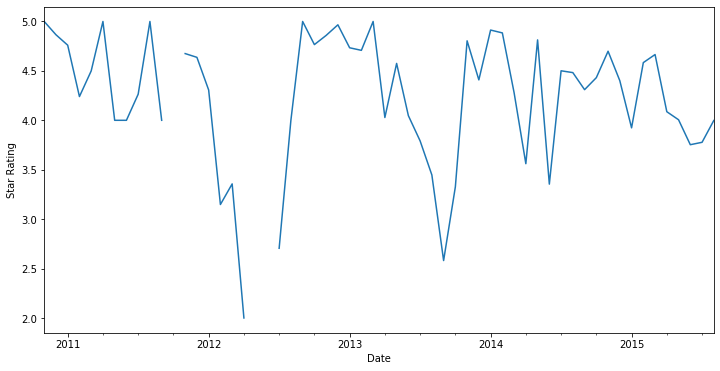

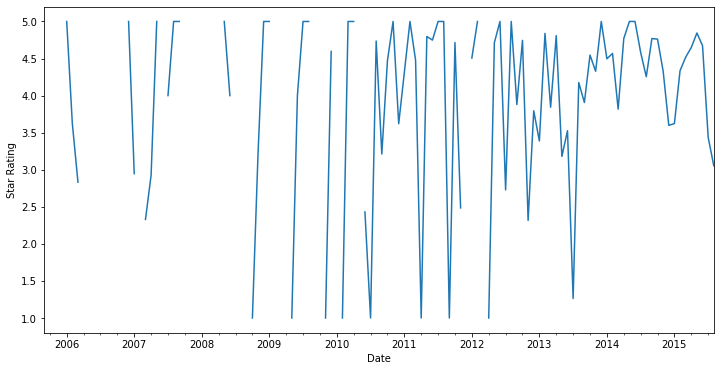

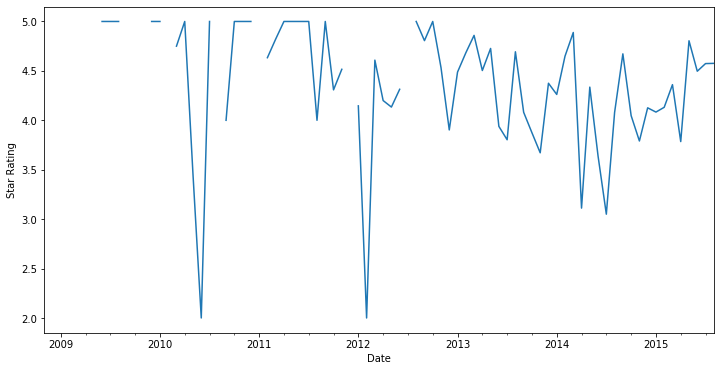

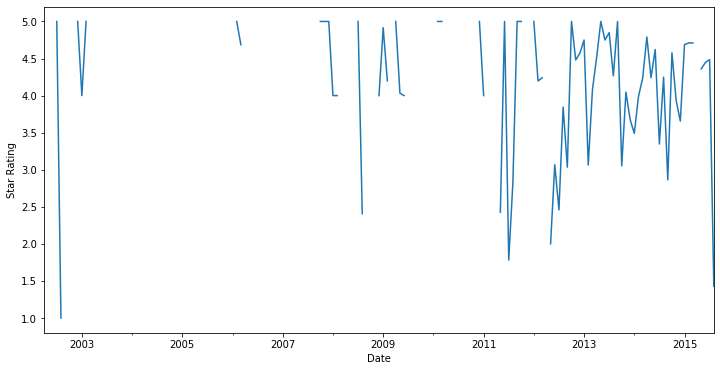

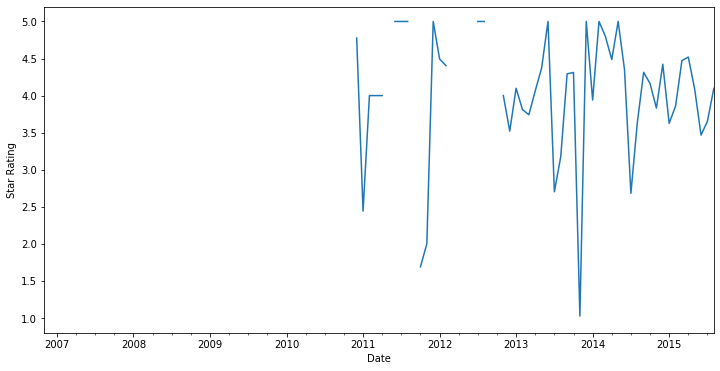

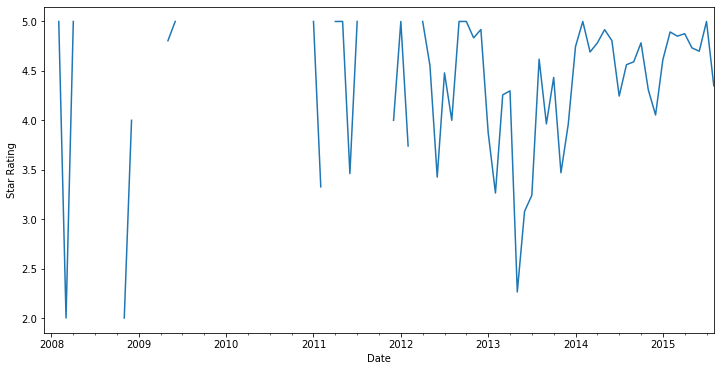

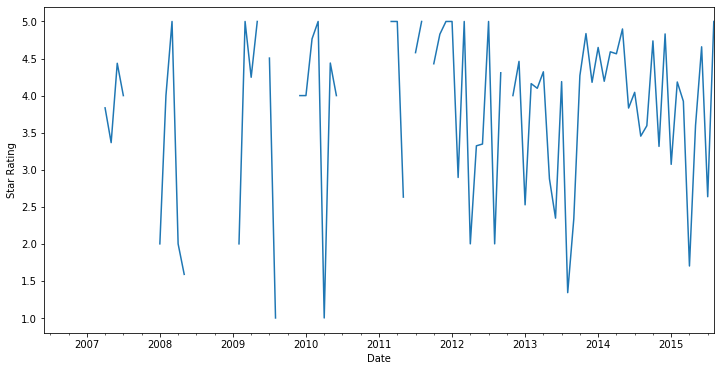

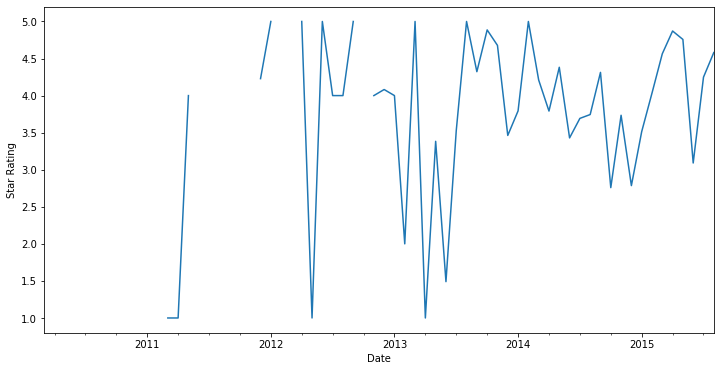

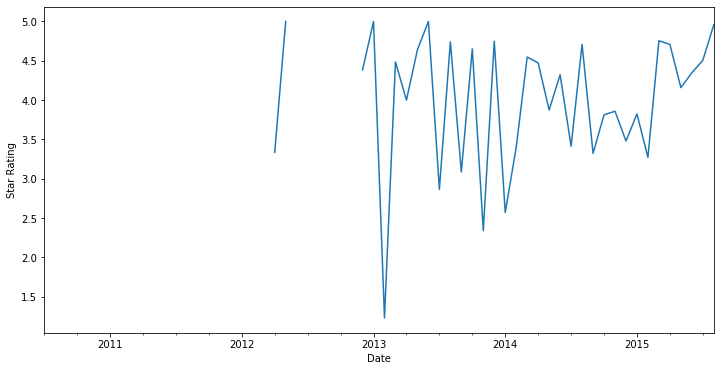

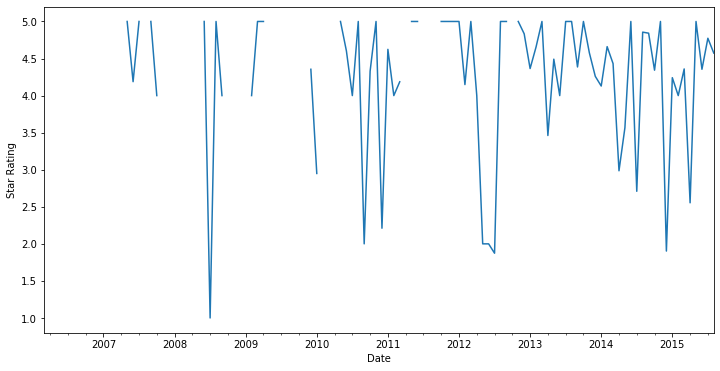

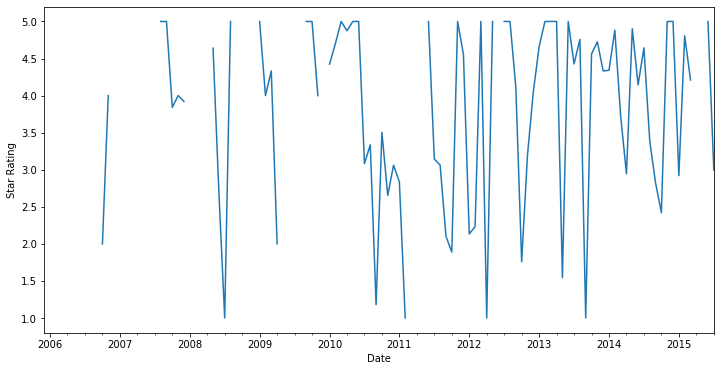

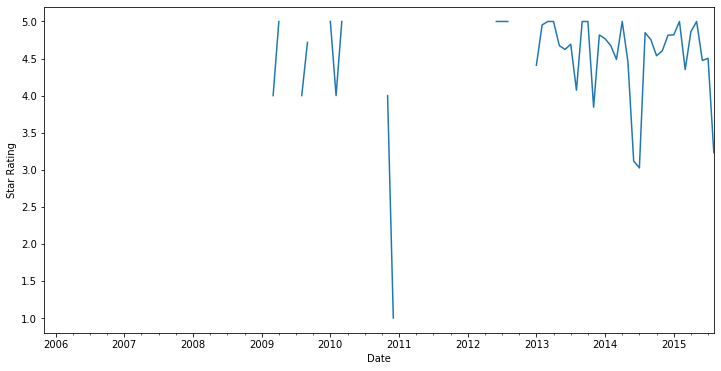

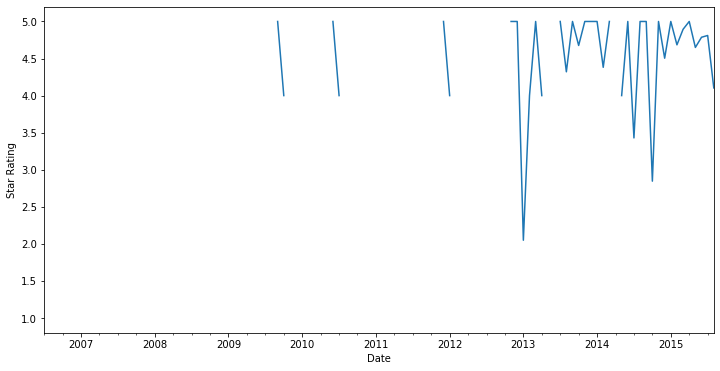

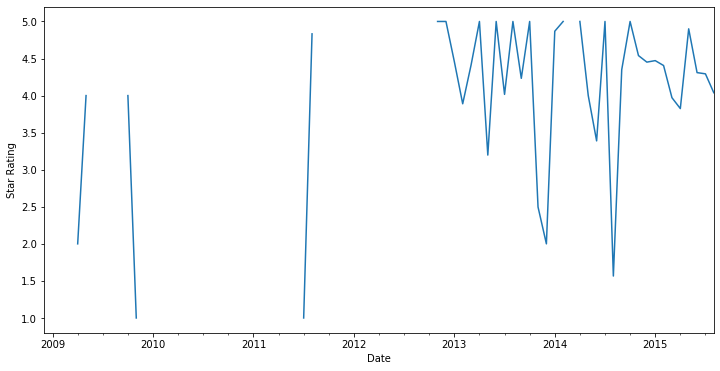

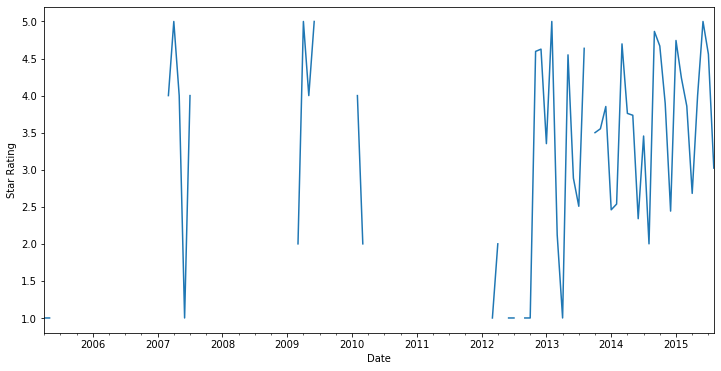

In [104]:
for i in range(15):
    title = final['product_title'].value_counts().index[i]
    XXXX = final[final['product_title']==title]
    month = XXXX.resample('M').sum()
    month['H/P'] = month['H']/month['P']
    month_dates = month['H/P']
    month_dates.sort_index(inplace=True)
    month_dates.plot(figsize=(12,6))
    plt.ylabel('Star Rating')
    plt.show()